In [1]:
from sackmann import get_data

In [2]:
# Use this to clone the data if you need it
!git clone https://github.com/JeffSackmann/tennis_atp.git

df = get_data('./tennis_atp/')

fatal: destination path 'tennis_atp' already exists and is not an empty directory.


In [3]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_rank_points,round_number,year,pts_won_serve_winner,pts_won_serve_loser,pts_played_serve_winner,pts_played_serve_loser,spw_winner,spw_loser,spw_margin
0,1968-580,Australian Chps.,Grass,64,G,1968-01-19,1,110023,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-580,Australian Chps.,Grass,64,G,1968-01-19,2,109803,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-580,Australian Chps.,Grass,64,G,1968-01-19,3,100257,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-580,Australian Chps.,Grass,64,G,1968-01-19,4,100105,5.0,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-580,Australian Chps.,Grass,64,G,1968-01-19,5,109966,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
rel_df = df[df['tourney_date'].dt.year >= 1960]

In [5]:
rel_df.shape

(158394, 58)

In [6]:
# We're going to fit a hierarchical model to rate tennis players.

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(rel_df['winner_name'].values.tolist() + rel_df['loser_name'].values.tolist())

names = encoder.classes_
winner_ids = encoder.transform(rel_df['winner_name'])
loser_ids = encoder.transform(rel_df['loser_name'])

In [8]:
from jax_advi.advi import optimize_advi_mean_field
from jax_advi.constraints import constrain_positive

theta_shapes = {
    'player_skills': (len(names)),
    'skill_prior_sd': ()
}

theta_constraints = {
    'skill_prior_sd': constrain_positive
}

In [9]:
len(names)

4763

In [10]:
from jax.scipy.stats import norm
from jax import jit
from jax.nn import log_sigmoid
import jax.numpy as jnp

@jit
def log_prior_fun(theta):
    
    # Prior
    skill_prior = jnp.sum(norm.logpdf(theta['player_skills'], 0., theta['skill_prior_sd']))
    
    # hyperpriors
    hyper_sd = norm.logpdf(theta['skill_prior_sd'])
    
    return skill_prior + hyper_sd

def log_lik_fun(theta, winner_ids, loser_ids):
    
    logit_probs = theta['player_skills'][winner_ids] - theta['player_skills'][loser_ids]
    
    return jnp.sum(log_sigmoid(logit_probs))

In [11]:
from functools import partial

curried_lik = jit(partial(log_lik_fun, winner_ids=winner_ids, loser_ids=loser_ids))

In [12]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, curried_lik, 
                                  constrain_fun_dict=theta_constraints, verbose=True, M=100)

159022.96166226472 38905.580968645045
150444.82619997975 3604.4700850484405
150130.24464299844 3461.2708257186323
149011.55759160526 2940.5253109797804
147119.61449312608 14027.970600211236
144142.4204003319 4513.902369487136
140373.2646173833 2867.284327078305
124323.03580545953 2403.5480770870063
118924.23774880148 2686.932547839327
112107.74946579822 2505.1419146767744
107324.60914612585 756.1596542439163
106480.05237041798 429.97941892568474
105937.01468529737 760.9475459727009
105643.67902358642 502.1686194641129
105065.12967699645 294.37075323492184
104641.29506161372 263.11844116533047
115812.70208422239 4942.957636986873
104617.78899724175 998.2947938207317
104264.046540824 441.44858983574284
104115.77884570726 267.7133873767813
103896.88664872825 206.5260533039016
103783.2930028467 206.19138608705003
103549.5516767148 164.29218508057028
103679.95165686731 719.0737368441013
103489.70393862737 321.34664414299095
103396.66315651988 142.7623446732422
103354.60791075323 112.6636229

In [13]:
import pandas as pd

mean_skills_advi = pd.Series(result['free_means']['player_skills'], index=names).sort_values(ascending=False)

In [14]:
print(mean_skills_advi.head(20).round(2).to_markdown())

|                       |    0 |
|:----------------------|-----:|
| Novak Djokovic        | 3.59 |
| Rafael Nadal          | 3.45 |
| Roger Federer         | 3.34 |
| Ivan Lendl            | 3.23 |
| Bjorn Borg            | 3.23 |
| John McEnroe          | 3.18 |
| Jimmy Connors         | 3.16 |
| Rod Laver             | 3.03 |
| Andy Murray           | 2.99 |
| Pete Sampras          | 2.92 |
| Boris Becker          | 2.83 |
| Andre Agassi          | 2.76 |
| Stefan Edberg         | 2.74 |
| Andy Roddick          | 2.72 |
| Juan Martin del Potro | 2.71 |
| Arthur Ashe           | 2.63 |
| Ken Rosewall          | 2.62 |
| Guillermo Vilas       | 2.6  |
| John Newcombe         | 2.54 |
| Mats Wilander         | 2.44 |


In [15]:
# Compare with stan
from stan_utils import load_stan_model_cached

stan_model = load_stan_model_cached('stan_tennis.stan')

In [16]:
stan_data = {
    'N': winner_ids.shape[0],
    'P': len(names),
    'winner_ids': winner_ids + 1,
    'loser_ids': loser_ids + 1
}

In [17]:
import numpy as np

# Uncomment if you want to fit the Stan model. It takes a while though!
#stan_fit = stan_model.sampling(data=stan_data)
stan_fit = np.load('./stan_samples.npz')

In [18]:
player_skills = stan_fit['player_skills']

In [19]:
mean_skills = player_skills.mean(axis=0)
advi_sds = result['free_sds']['player_skills']

In [20]:
mean_skills = pd.Series(mean_skills, index=names)

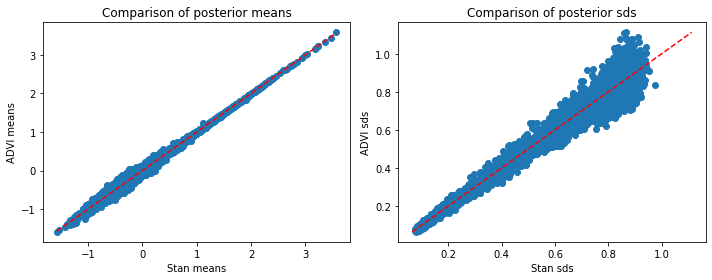

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2)

ax[0].scatter(mean_skills, mean_skills_advi.loc[mean_skills.index])
ax[0].plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

ax[1].scatter(player_skills.std(axis=0), advi_sds)
ax[1].plot([advi_sds.min(), advi_sds.max()], [advi_sds.min(), advi_sds.max()], linestyle='--', color='r')

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('tennis_comparison.png', dpi=300)

In [22]:
import numpy as np

# Save the Stan samples.
#np.savez('stan_samples', **stan_fit.extract())

In [23]:
# Try Stan's ADVI
vb_result_stan = stan_model.vb(data=stan_data, )

In [25]:
vb_result_stan.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [30]:
stan_advi_res = [y for x, y in zip(vb_result_stan['mean_par_names'], vb_result_stan['mean_pars']) 
 if 'player_skills[' in x]

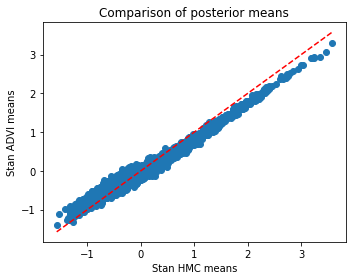

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(mean_skills, stan_advi_res)
plt.plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

plt.title('Comparison of posterior means')

plt.xlabel('Stan HMC means')
plt.ylabel('Stan ADVI means')

plt.gcf().set_size_inches(5, 4)
plt.gcf().tight_layout()

plt.savefig('tennis_comparison_stan_advi.png', dpi=300)

